In [1]:
import pandas as pd

import nltk
from nltk.corpus import stopwords

import pymorphy2
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from utils import *

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmitry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Токенизация данных

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

### Токенизация данных

In [3]:
stop_words = stopwords.words("russian")
extra_stop_words = get_stopwords_from_file("stopwords.txt")
stop_words_extended = set(stop_words + extra_stop_words)

In [4]:
morph = pymorphy2.MorphAnalyzer()


def process_string(input_string, morph=morph, stop_words=stop_words_extended):
    words = re.findall(r"\b[а-яА-Я_]+\b", input_string)
    result_string = " ".join(
        [
            word if "_" in word else morph.parse(word)[0].normal_form
            for word in words
            if word not in stop_words
        ]
    )

    return result_string


df_train["text_employer"] = df_train["text_employer"].apply(process_string)
df_test["text_employer"] = df_test["text_employer"].apply(process_string)

## Классифкация

**Модель**: TF-IDF Vectorizer + SGDClassifier. Почему?
1. Модель показывает хорошие результаты при работе с текстом
2. Модель имеет высокую скорость работы

Следующие эксперименты направлены на улучшение ее результатов

In [5]:
def get_tfidf_vectorization(df_train, df_test, col):
    tfidf_vectorizer = TfidfVectorizer()
    X_train = tfidf_vectorizer.fit_transform(df_train[col])
    X_test = tfidf_vectorizer.transform(df_test[col])

    y_train = df_train["category"]
    y_test = df_test["category"]
    return X_train, X_test, y_train, y_test


def get_baseline_results(df_train, df_test, col="text_employer", class_weight=None):
    X_train, X_test, y_train, y_test = get_tfidf_vectorization(
        df_train, df_test, col=col
    )

    clf = SGDClassifier(
        max_iter=1000, loss="hinge", class_weight=class_weight, random_state=42
    )  # SVM
    clf.fit(X_train, y_train)

    print(classification_report(y_test, clf.predict(X_test)))

### 1. Влияние последовательностей слов, записанных через нижнее подчеркивание

In [6]:
get_baseline_results(df_train, df_test, col="text_employer")

                            precision    recall  f1-score   support

              Бизнес-карта       0.78      0.92      0.85      4572
        Зарплатные проекты       0.86      0.72      0.78      2939
Открытие банковского счета       0.72      0.64      0.68      1530
                 Эквайринг       0.88      0.72      0.79       994

                  accuracy                           0.80     10035
                 macro avg       0.81      0.75      0.78     10035
              weighted avg       0.81      0.80      0.80     10035



In [7]:
df_train["text_employer_no_ul"] = df_train["text_employer"].apply(
    lambda x: x.replace("_", " ")
)
df_test["text_employer_no_ul"] = df_test["text_employer"].apply(
    lambda x: x.replace("_", " ")
)

get_baseline_results(df_train, df_test, col="text_employer_no_ul")

                            precision    recall  f1-score   support

              Бизнес-карта       0.78      0.93      0.85      4572
        Зарплатные проекты       0.88      0.71      0.78      2939
Открытие банковского счета       0.71      0.64      0.67      1530
                 Эквайринг       0.87      0.72      0.79       994

                  accuracy                           0.80     10035
                 macro avg       0.81      0.75      0.77     10035
              weighted avg       0.80      0.80      0.79     10035



**Вывод:** Векторизация способна учитывать слова как записанные слитно, так и раздельно

**Далее** рассматриваю последовательности как отдельные слова

### 2. Ошибки в лейблах
Я заметил, что двольно много диалогов не содержит достаточной информации для того, чтобы их можно было верно классифицировать. Первая идея: отсеять по количеству реплик, однако существуют диалоги, состоящие из одной длинной реплики. Более стабильный критерий: количество слов. Эмпирически я установил минимальное количество слов, при котором большая часть ложных классифкаций отбрасывается: **20**

In [8]:
for d in df_train[df_train["text_employer"].apply(lambda x: len(str(x).split())) < 20][
    "text_employer"
][:10]:
    print(d, "\n")

добрый_день звать сбербанк_клиентский_менеджер блок сбер бизнес звонить индивидуальный_предприниматель удобно поговорить перезвонить ориентировочно перезвонить добрый 

персональный сбербанк_бизнес звонить организация музалеть удобно паспорт точно торговый сбербанк хотеть уточнить операция подключить 

добрый_день звать звать сбербанк блок сбер бизнес звонить индивидуальный_предприниматель удобно разговаривать предложение хотеть обсудить сказать работать сотрудник штат удобный 

звонить индивидуальный_предприниматель удобно услышать перезвонить добрый 

добрый_день персональный_менеджер сбер бизнес перезванивать удобно добавить первый удобно разговаривать 

добрый_день перезвонить добрый 

здравствуйте персональный_менеджер сбербанк_бизнес ип давтянин звонить удобно честно переговорить вопрос перезвонить уточнить перезвонить добрый свидание 

добрый_день персональный_менеджер сбер бизнес звонить индивидуальный_предприниматель удобно разговаривать однозначно звонок удобно принять перезв

In [9]:
threshold_length = 30
df_train_mod = df_train[
    df_train["text_employer"].apply(lambda x: len(str(x).split())) > threshold_length
]
df_test_mod = df_test[
    df_test["text_employer"].apply(lambda x: len(str(x).split())) > threshold_length
]

get_baseline_results(df_train_mod, df_test_mod, col="text_employer")

                            precision    recall  f1-score   support

              Бизнес-карта       0.96      0.97      0.96      3194
        Зарплатные проекты       0.93      0.91      0.92      1968
Открытие банковского счета       0.85      0.85      0.85      1018
                 Эквайринг       0.88      0.89      0.89       744

                  accuracy                           0.93      6924
                 macro avg       0.91      0.91      0.91      6924
              weighted avg       0.93      0.93      0.93      6924



In [10]:
threshold_length = 20
df_train_mod = df_train[
    df_train["text_employer"].apply(lambda x: len(str(x).split())) > threshold_length
]
df_test_mod = df_test[
    df_test["text_employer"].apply(lambda x: len(str(x).split())) > threshold_length
]

get_baseline_results(df_train_mod, df_test_mod, col="text_employer")

                            precision    recall  f1-score   support

              Бизнес-карта       0.91      0.96      0.94      3572
        Зарплатные проекты       0.91      0.88      0.89      2237
Открытие банковского счета       0.83      0.80      0.82      1127
                 Эквайринг       0.90      0.84      0.87       816

                  accuracy                           0.90      7752
                 macro avg       0.89      0.87      0.88      7752
              weighted avg       0.90      0.90      0.90      7752



**Выводы:** 
1. Неправильные метки сильно влияют на итоговые метрики. Возможно на инференсе стоит добавить еще один класс, который будет означать, что данных для определения недостаточно.
2. Поиск примеров с ложными метками — отдельная задача, которая может решаться, например, с помощью:
   * кластерного анализа
   * анализа векторов характеристик
   * анализа семантики предложения — наличия или отсутствия ключевых слов
  
**Далее** я остановился на отсечении по количеству слов в диалоге (20)

### 3. Сбалансированные веса классов

In [11]:
get_baseline_results(df_train_mod, df_test_mod, col="text_employer")

                            precision    recall  f1-score   support

              Бизнес-карта       0.91      0.96      0.94      3572
        Зарплатные проекты       0.91      0.88      0.89      2237
Открытие банковского счета       0.83      0.80      0.82      1127
                 Эквайринг       0.90      0.84      0.87       816

                  accuracy                           0.90      7752
                 macro avg       0.89      0.87      0.88      7752
              weighted avg       0.90      0.90      0.90      7752



In [12]:
get_baseline_results(
    df_train_mod, df_test_mod, col="text_employer", class_weight="balanced"
)

                            precision    recall  f1-score   support

              Бизнес-карта       0.96      0.92      0.94      3572
        Зарплатные проекты       0.92      0.87      0.89      2237
Открытие банковского счета       0.72      0.86      0.79      1127
                 Эквайринг       0.83      0.86      0.85       816

                  accuracy                           0.89      7752
                 macro avg       0.86      0.88      0.87      7752
              weighted avg       0.90      0.89      0.89      7752



**Вывод:** взвешивание по классам повышает recall малочисленных классов, что может быть важно

**Далее** использую сбалансированный подход

### 4. Очень простая аугментация классов

Как можно аугментировать:
1. Сгенерировать случайные данные из распределений совокупности слов для каждого класса:
* +: при tf-idf векторизации порядок слов слов и семантическая логика неважна, поэтому текстам необязательно быть осмысленными,
* \-: тексты могут получиться совсем неосмысленными, а также базовые паттерны диалогов с приветствием, представлением, прощанием и др. теряются в самом простом случае генерации
2. Добавлять шумы в векторы td-idf:
* +: простая реализация
* \-: небольшой шум создает векторы, имеющие маленькое косинусное расстояние с исходными, что будет давать слабую аугментацию, большой — напротив, может сделать примеры вовсе меняющие метку

Я попробовал первый подход с очень примитивным семплированием

In [13]:
df_augmented = augment_data(
    df_train_mod, text_col="text_employer", min_words=20, max_words=160
)
df_augmented["text_employer"].iloc[-1], df_augmented["category"].iloc[-1]

('который разговаривать действовать давать понять линия вопрос возможно терминал вопрос оплата заниматься кредитный_карта оборудование рубль область сбер левый линия параметр верно отделение_банка заявка раздел руководитель индивидуальный_предприниматель отправить плохо нету актуальность сфера комиссия звать отделение_банка задать дочка усилие рассчитываться терминал прощаться владелец смочь уточнить данный бизнес возникнуть пользоваться организация конец подключать направить добрый_день комиссия верно какой линия сотрудник банк личный_кабинет инструкция сотка услуга сбербанк потребоваться установить обсудить сбер удобно большинство вопрос следующий остаться дистанционно выпустить понадобиться заявка давать хороший соединение расчётный счёт бесплатно переносить поддержка здравствуйте смотреть оборот получаться вопрос средство зависеть отметить обратиться продукт_банка наверное получить приложение день процент услуга звонить продукт посылать звонить сервисный один индивидуальный_предпри

In [14]:
get_baseline_results(df_augmented, df_test_mod, col="text_employer")

                            precision    recall  f1-score   support

              Бизнес-карта       0.94      0.93      0.93      3572
        Зарплатные проекты       0.92      0.86      0.89      2237
Открытие банковского счета       0.76      0.84      0.80      1127
                 Эквайринг       0.84      0.86      0.85       816

                  accuracy                           0.89      7752
                 macro avg       0.86      0.87      0.87      7752
              weighted avg       0.89      0.89      0.89      7752



**Вывод** результат на самом деле удивил — небольшое отклонение в метриках, решение получилось двольно авантюрным

**Далее** я решил не использовать этот метод

### 5. GridSearch по параметрам TfidfVectorizer и SGDClassifier

In [15]:
param_grid = {
    "tfidf__max_features": [500, 1000, 2000, 5000],
    "tfidf__norm": ["l1", "l2"],
    "tfidf__ngram_range": [(1, 1), (1, 3)],
    "classifier__penalty": ["l2", "l1", "elasticnet", None],
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
}

In [16]:
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("classifier", SGDClassifier(class_weight="balanced", random_state=42)),
    ]
)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=2, scoring="accuracy", verbose=1, n_jobs=5
)
grid_search.fit(df_train_mod["text_employer"], df_train_mod["category"])

Fitting 2 folds for each of 192 candidates, totalling 384 fits


/Users/dmitry/PycharmProjects/skbt_test/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(class_weight='balanced',
                                                      random_state=42))]),
             n_jobs=5,
             param_grid={'classifier__loss': ['hinge', 'log_loss',
                                              'modified_huber'],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet',
                                                 None],
                         'tfidf__max_features': [500, 1000, 2000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 3)],
                         'tfidf__norm': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [17]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'classifier__loss': 'modified_huber', 'classifier__penalty': None, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l1'}


In [18]:
best_model = grid_search.best_estimator_
best_model.fit(df_augmented["text_employer"], df_augmented["category"])

# Оценка модели на тестовых данных
y_pred = best_model.predict(df_test_mod["text_employer"])
print(classification_report(df_test_mod["category"], y_pred))

                            precision    recall  f1-score   support

              Бизнес-карта       0.92      0.95      0.93      3572
        Зарплатные проекты       0.90      0.88      0.89      2237
Открытие банковского счета       0.83      0.81      0.82      1127
                 Эквайринг       0.89      0.82      0.86       816

                  accuracy                           0.90      7752
                 macro avg       0.88      0.87      0.87      7752
              weighted avg       0.90      0.90      0.90      7752



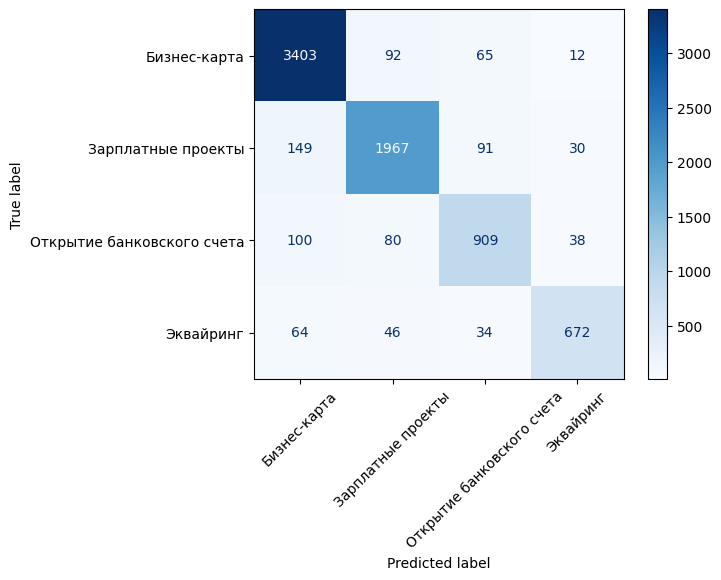

In [19]:
cm = confusion_matrix(df_test_mod["category"], y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

## Что дальше?

Дальше нужно смотреть, на каких примерах модель ошибается, чтобы понять почему. Можно рассмотреть и дргуие подходы к векторизации, а также использовать нелинейные модели классификации

In [20]:
df_test_mod["pred"] = y_pred
df_cls_errors = df_test_mod[df_test_mod["pred"] != df_test_mod["category"]][
    ["text_employer", "category", "pred"]
]

/var/folders/fm/2896yrmn581cyl4g1mqkzj_r0000gn/T/ipykernel_13441/3781991859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_mod['pred'] = y_pred


In [21]:
for i, row in df_cls_errors[:1].iterrows():
    print(row.text_employer, "\n", row.category, "-", row.pred)

добрый_день бизнес персональный_менеджер организация спектр звонить удобно беседовать верно побеседовать вопрос банковский обслуживание подсказать последний цифра номер указать ноль какой номер связаться хороший понять информация хороший продолжение день желать добрый свидание 
 Бизнес-карта - Открытие банковского счета


In [22]:
df_cls_errors.to_csv("df_cls_errors.csv")

In [24]:
import pickle

pickle.dump(best_model, open("best_classifier.sav", "wb"))